<a href="https://colab.research.google.com/github/ko4ro/Variational-Autoencoder-Numpy/blob/master/VAE_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder(VAE) in Numpy

# モジュールインポート

In [13]:
import os
import pickle
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets
import numpy as np
# try:
#     print("cupy")
#     import cupy as np
# except ImportError:
#     print("numpy")
#     import numpy as np

%matplotlib inline

# MNISTデータ準備

In [14]:
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target

# if np.__name__=='cupy':  #cupyの場合はcupyのndarrayに変換
#     X = np.asarray(X) 

# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)
x_train = x_train.astype('float32') / 255.          #各ピクセルの値を[0,1]に変換
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.astype('float32') / 255.            #各ピクセルの値を[0,1]に変換
x_test = x_test.reshape(-1,1,28,28)

## データの確認

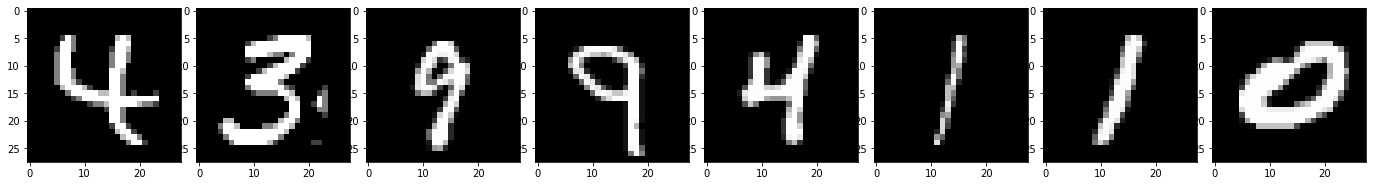

In [15]:
rows_count = 1    #行
columns_count = 8 #列

idx = 0
fig = plt.figure(figsize=(columns_count*3,3 ))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(0, columns_count):
    ax_org=fig.add_subplot(rows_count, columns_count,i+1)
    # if np.__name__=='cupy':                       #cupyの場合はnumpyのndarrayに変換
    #     imgs = np.asnumpy(x_train[i+idx][0])
    # else:
    imgs = x_train[i+idx][0]
    ax_org.imshow(imgs, cmap='gray')
    # ax_org.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False) #目盛非表示

plt.show()

# Common 

## Layars

In [16]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

def glorot_uniform(size, fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.rand(size) * 2 *limit - limit

def initialise_weight(in_channel, out_channel):
    W = np.random.randn(in_channel, out_channel).astype(np.float32) * np.sqrt(2.0/(in_channel))
    return W

class Affine:
    def __init__(self, input_size, output_size):
        self.W = glorot_uniform(input_size*output_size, input_size, output_size).reshape(input_size, output_size)
        #self.W = initialise_weight(input_size, output_size)
        self.b = np.zeros(output_size)
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx
    
class Reshape:
    def __init__(self, next_x_shape):
        self.original_x_shape = None
        self.next_x_shape = next_x_shape

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape  #変換前のshape
        batchsize = self.original_x_shape[0]
        out = x.reshape((batchsize,) + self.next_x_shape)
        return out

    def backward(self, dout):      
        dx = dout.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class MSEWithLoss:
    def __init__(self):
        self.loss = None
        self.x = None # 
        self.t = None # 教師データ

    def forward(self, x, t):
        self.x = x
        self.t = t
        self.loss = np.mean(np.square(self.t - self.x))
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = 2*(self.x - self.t)  / batch_size
        return dx


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def cross_entropy_error(y, t):
    #y.shape=(N,C,H,W)
    #交差エントロピー  
    batchsize = y.shape[0]
    delta = 1e-7
    return -np.sum(t*np.log(y + delta) + (1-t)*np.log(1-y + delta)) / batchsize

class SigmoidWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # sigmoidの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = sigmoid(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)*self.y*(1-self.y)  / batch_size
        
        return dx

## Optimizers

In [17]:
class RMSprop:
    """RMSprop"""
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# NetworkModel

## Encoder

In [18]:
class Encoder:
    def __init__(self, latent_dim):
      
        self.latent_dim = latent_dim

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Reshape'] = Reshape(next_x_shape=(784,))  #shape変換(batch除く)
        self.layers['Affine1'] = Affine(784, 512)
        self.layers['Relu1'] = Relu()
        self.layers_mu = Affine(512,  self.latent_dim)         #Affine変換 潜在変数(32次元)空間上でのガウス分布の平均
        self.layers_logvar = Affine(512,  self.latent_dim)     #Affine変換 潜在変数(32次元)空間上でのガウス分布の分散の対数
                
        # 重みの初期化
        self.params = {}
        self.params['W1'] = self.layers['Affine1'].W
        self.params['b1'] = self.layers['Affine1'].b
        self.params['W2'] = self.layers_mu.W
        self.params['b2'] = self.layers_mu.b
        self.params['W3'] = self.layers_logvar.W
        self.params['b3'] = self.layers_logvar.b
        
        #出力 平均、分散
        self.latent_mu = None
        self.latent_logvar = None
        self.rand_sample = None
        self.batch_size = None

    def forward(self, x):

        for layer in self.layers.values():
            x = layer.forward(x)

        self.latent_mu = self.layers_mu.forward(x)
        self.latent_logvar = self.layers_logvar.forward(x)
        
        self.batch_size = x.shape[0]

        self.rand_sample = np.random.standard_normal(size=(self.batch_size, self.latent_dim))    #標準正規分布N～(0,I)からサンプリングしたデータ
        self.sample_z = self.latent_mu + np.exp(self.latent_logvar * 0.5) * self.rand_sample
        
        return self.sample_z, self.latent_mu, self.latent_logvar

    def loss(self, x):
        """損失関数（KLダイバージェンス）を求める
        引数のxは入力データ
        """
        self.forward(x)

        loss = -0.5 * np.sum(1 + self.latent_logvar - self.latent_mu**2 - np.exp(self.latent_logvar)) / (self.batch_size * self.latent_dim)
        return loss

    def backward(self, x, dout_dec):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        dout_dec : decoderから誤差逆伝播で伝わってきた勾配 (N,D)
        """
        ## forward
        self.loss(x)

        ## backward

        # Rreconstruction Errorの勾配
        drec_mu = dout_dec
        drec_logvar = dout_dec*0.5*np.exp(self.latent_logvar*0.5)*self.rand_sample

        # KLダイバージェンスの勾配
        dkl_mu = self.latent_mu / (self.batch_size * self.latent_dim)
        dkl_logvar = 0.5*(np.exp(self.latent_logvar)-1) / (self.batch_size * self.latent_dim)

        #勾配合算
        dout_mu = drec_mu + dkl_mu
        dout_logvar = drec_logvar + dkl_logvar

        #lastlayerのbackward
        dout_mu = self.layers_mu.backward(dout_mu)
        dout_logvar = self.layers_logvar.backward(dout_logvar)

        #各勾配mu,logvarを足し合わせる
        dout = dout_mu + dout_logvar        
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers_mu.dW, self.layers_mu.db
        grads['W3'], grads['b3'] = self.layers_logvar.dW, self.layers_logvar.db
        return grads

## Decoder

In [19]:
class Decoder:
    def __init__(self,latent_dim):

        self.latent_dim = latent_dim

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.latent_dim, 512)
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(512, 784)
        self.layers['Reshape'] = Reshape(next_x_shape=(1,28,28))

        self.last_layer = MSEWithLoss()
        #self.last_layer = SigmoidWithLoss()
        
        self.dout = None
                
        # 重みの初期化
        self.params = {}
        self.params['W1'] = self.layers['Affine1'].W
        self.params['b1'] = self.layers['Affine1'].b
        self.params['W2'] = self.layers['Affine2'].W
        self.params['b2'] = self.layers['Affine2'].b

        self.loss_Rec = None

    def forward(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x

    def loss(self, z, t):
        """損失関数（Reconstruction Error）を求める
        Parameters
        ----------
        z : 入力データ
        t : 教師ラベル
        """
        y = self.forward(z)
        return self.last_layer.forward(y, t)
        
    def backward(self, z, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        z : 入力データ
        t : 教師ラベル
        """
        # forward
        self.loss_Rec = self.loss(z, t)

        # backward
        self.dout = 1
        self.dout = self.last_layer.backward(self.dout)   #MSEの勾配

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            self.dout = layer.backward(self.dout)         #self.dout は decoderの入力テンソルの勾配 これをエンコーダに逆伝播させる
        
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## VAE

In [20]:
class VAE:
    """Variational AutoEncoder"""
    def __init__(self, latent_dim):

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
        self.optimizer_enc = RMSprop(lr=0.001, decay_rate = 0.9)  #Adam(lr=1e-4, beta1=0.5, beta2=0.999)
        self.optimizer_dec = RMSprop(lr=0.001, decay_rate = 0.9)  #Adam(lr=1e-4, beta1=0.5, beta2=0.999)
    
    def forward(self, x):
        mu, logvar = self.encoder.forward(x)
        z, _ = self.reparametrize(mu, logvar)
        recon_x = self.decoder.forward(z)
        return recon_x, mu, logvar
    
    def loss(self, x):
        """損失関数を求める
        引数のxは入力データ (N,C,H,W)
        """
        Dkl_loss = self.encoder.loss(x)
        
        mu, logvar = self.encoder.forward(x)
        z, _ = self.reparametrize(mu, logvar)
        Rec_loss = self.decoder.loss(z,x)
        
        total_loss = Dkl_loss + Rec_loss
        return total_loss

    def train(self, x_train, epochs=2, batch_size=16, optimizer=None):
        """学習"""

        DKL_loss_array = np.array([])
        REC_loss_array = np.array([])

        np.random.shuffle(x_train)

        for ep in range(epochs):
            print("epochs = ",ep)
            
            for idx in np.arange(0, len(x_train), batch_size):
                print("idx = ",idx)
                x = x_train[idx:idx+batch_size]

                DKL_loss = self.encoder.loss(x)

                #decoder optimize
                dec_grads = self.decoder.backward(self.encoder.sample_z, x)
                self.optimizer_dec.update(self.decoder.params, dec_grads)
                
                #encoder optimize
                enc_grads = self.encoder.backward(x, self.decoder.dout)
                self.optimizer_enc.update(self.encoder.params, enc_grads)
                
                REC_loss = self.decoder.loss_Rec
                
                #Loss
                DKL_loss_array = np.concatenate((DKL_loss_array, np.atleast_1d(DKL_loss)))
                REC_loss_array = np.concatenate((REC_loss_array, np.atleast_1d(REC_loss)))
                print("mu, sigma = ", np.mean(self.encoder.latent_mu), np.mean(np.exp(self.encoder.latent_logvar*0.5)) , " | DKL Loss = ", DKL_loss, " REC Loss = ",  REC_loss, " | Total Loss = ", DKL_loss + REC_loss)
        
        history = [DKL_loss_array, REC_loss_array]
        return history

# 学習

In [21]:
vae = VAE(latent_dim=2)
history = vae.train(x_train, batch_size=64, epochs=2)

epochs =  0
idx =  0
mu, sigma =  0.19233185321738938 0.9708066482987139  | DKL Loss =  0.08873012192425139  REC Loss =  0.11218674713657062  | Total Loss =  0.200916869060822
idx =  64
mu, sigma =  -1.578694006707932 1.3190222909082918  | DKL Loss =  3.6239129705496382  REC Loss =  0.09838487168259692  | Total Loss =  3.7222978422322353
idx =  128
mu, sigma =  0.2813823153728229 0.929851523222579  | DKL Loss =  0.30376851743183786  REC Loss =  0.09684337137998937  | Total Loss =  0.40061188881182724
idx =  192
mu, sigma =  1.181831971628442 0.8112005176876704  | DKL Loss =  4.124377173647197  REC Loss =  0.07672832146871301  | Total Loss =  4.20110549511591
idx =  256
mu, sigma =  -0.05467930464220184 0.8554159181700751  | DKL Loss =  0.4523460014948173  REC Loss =  0.0887521325729373  | Total Loss =  0.5410981340677546
idx =  320
mu, sigma =  0.015248499201391041 0.6217434645439404  | DKL Loss =  2.2729622998203567  REC Loss =  0.07077971421872149  | Total Loss =  2.343742014039078
i

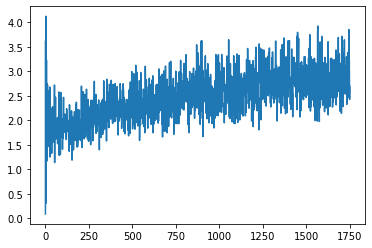

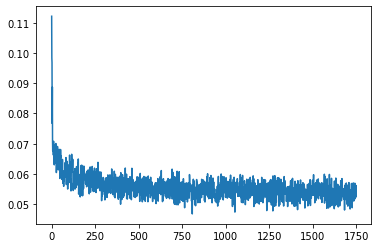

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(history[0])
plt.show()
plt.plot(history[1])
plt.show()

# 生成画像の確認
上段がテストデータの入力画像、下段が入力画像をもとにVAEが生成した画像

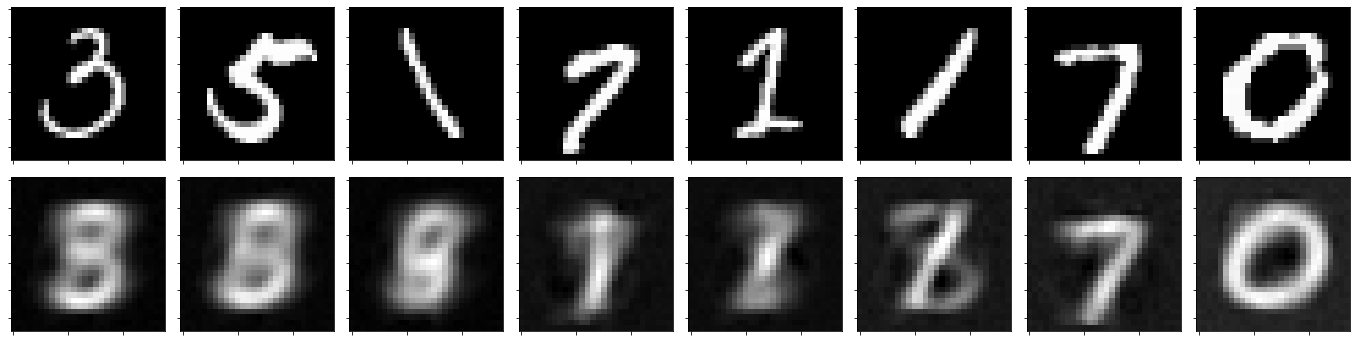

In [24]:
rows_count = 2    #行
columns_count = 8 #列

idx = np.random.randint(0, len(x_test)-columns_count)        #ランダムにテストデータ選択
#idx = 0
x = x_test[idx:idx+columns_count]
z, mu, logvar= vae.encoder.forward(x)
recon_x = vae.decoder.forward(z)
# if np.__name__=='cupy':                          #cupyの場合はnumpyのndarrayに変換
#     recon_x = np.asnumpy(recon_x)

fig = plt.figure(figsize=(columns_count*3,6 ))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(0, columns_count):
    ax_org=fig.add_subplot(rows_count, columns_count,i+1)
    # if np.__name__=='cupy':                       #cupyの場合はnumpyのndarrayに変換
    #     imgs = np.asnumpy(x[i][0])
    # else:
    imgs = x[i][0]
    ax_org.imshow(imgs, cmap='gray')
    ax_gen=fig.add_subplot(rows_count, columns_count,i+1+columns_count)
    ax_gen.imshow(recon_x[i][0], cmap='gray')
    ax_org.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False) #目盛非表示
    ax_gen.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False) #目盛非表示

plt.show()

### 隠れ変数z_meanの可視化
encoderにx_testを入力することで、隠れ変数のz_meanを出力する

In [25]:
# 入力を潜在空間に投影するためのモデル

z, mu, logvar= vae.encoder.forward(x_test)


# one-hotベクトルに変換
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(range(np.max(t_test)+1))
# y_test = label_binarizer.transform(t_test)

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(t_test)


(14000, 1, 28, 28)
(14000, 2)
(14000,)
(14000,)
9
(14000, 10)
[9 2 5 ... 9 2 7]


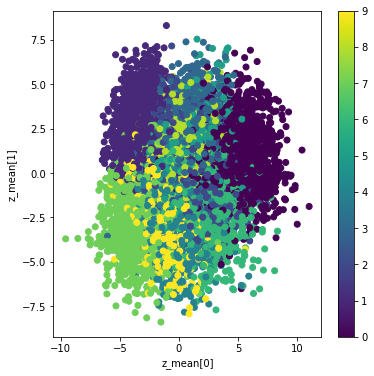

In [26]:
# # テストデータを入力して潜在空間に2次元プロットする 正解ラベルを色で表示
plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(y_test, axis=1))
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.colorbar()
plt.show()

### 画像を生成し表示
decoderにz_sampleを入力し、画像を生成する。z_sampleは、2次元標準正規分布からサンプリングされた値を想定している。

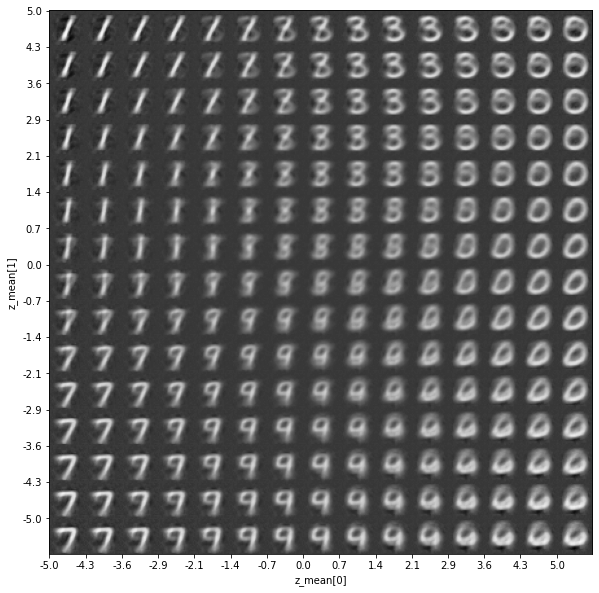

In [27]:
# 画像を並べて表示
n = 15  # 画像を15個x15個並べて表示
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 2次元標準正規分布を作成してグリッドにする
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)


# 2次元標準正規分布の各値をdecoderに入力し、画像を生成
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z = np.array([[xi, yi]])
        # x_decoded = generator.predict(z_sample)
        recon_x = vae.decoder.forward(z)
        digit = recon_x[0].reshape(digit_size, digit_size)
        figure[(len(grid_y)-1-j) * digit_size: (len(grid_y)-1-j+1) * digit_size,
                       i * digit_size: (i+1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.yticks(np.arange(0,n*28,28), grid_y[::-1].round(1)) # [::-1]をつけると逆順になる
plt.xticks(np.arange(0,n*28,28), grid_x.round(1))
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.show()